## Find the best binary classifier for a given dataset
### Imports

In [1]:
# Libraries
import pandas as pd
import numpy as np
import sklearn.datasets as data
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns

# Algorithms
from MachineLearning.SupervisedLearning.LogisticRegression.Classification.functions import *
from MachineLearning.SupervisedLearning.NaiveBayes.Classification.functions import *
from MachineLearning.SupervisedLearning.NearestNeighbors.Classification.functions import *
from MachineLearning.SupervisedLearning.SVM.Classification.functions import *
from MachineLearning.SupervisedLearning.DecisionTree.Classification.functions import *

# Silence convergence warnings
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.simplefilter("ignore", category=ConvergenceWarning)



### Load dataset

In [2]:
X, y = data.load_breast_cancer(return_X_y=True)

# Limit to two features
X = X[:,:2]

# Create train/test splits (train_test_split() automatically uses a stratified split based on class labels)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=42)

### Visualize high-dimensional data using t-SNE

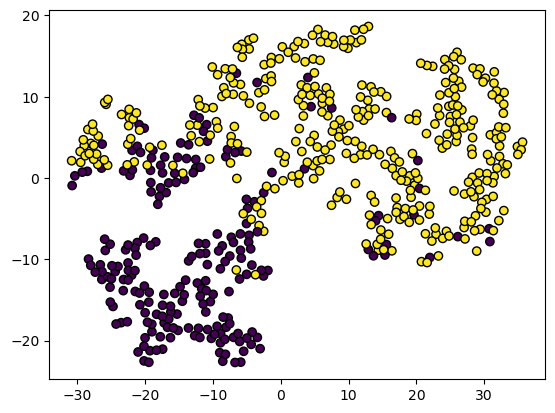

In [3]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=30).fit_transform(X)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, edgecolor="k")


### Specify metrics
Specify which metrics to judge the algorithm performance on. Options:
- **Accuracy:**
- **Precision:**
- **Recall:**
- **F1:**

In [4]:
scoring = "accuracy"  # TODO: Add possibility of selecting multiple scoring functions

### Set hyperparameter ranges

In [5]:
logistic_regression_parameters = {
    "C_range" : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

naive_bayes_parameters = {
    "var_smoothing" : [0.000000001, 0.00000001]
}

knn_parameters = {
    "k_range": [i for i in range(1, 10)]
}

SVM_parameters = {
    "kernels" : ["linear", "poly", "rbf", "sigmoid"],
    "C_range": [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

decision_tree_parameters = {
    "criterion" : ["gini", "entropy", "log_loss"],
}


### Run algorithms /w 10-fold cross-validation

In [6]:
# Run logistic regression
logistic_regression_results, logistic_regression_best_estimator, logistic_regression_best_score \
    = logistic_regression_gridsearch(X_train, y_train, logistic_regression_parameters, scoring=scoring)

# Run Naive Bayes
naive_bayes_results, naive_bayes_best_estimator, naive_bayes_best_score = naive_bayes_gridsearch(
    X_train, y_train, naive_bayes_parameters, scoring=scoring)

# Run k-NN
knn_results, knn_best_estimator, knn_best_score = knn_gridsearch(
    X_train, y_train, knn_parameters, scoring=scoring)

# # Run SVM
SVM_results, SVM_best_estimator, SVM_best_score = SVM_gridsearch(
    X_train, y_train, SVM_parameters, scoring=scoring)

# Run decision tree
decision_tree_results, decision_tree_best_estimator, decision_tree_best_score = decision_tree_gridsearch(
    X_train, y_train, decision_tree_parameters, scoring=scoring)



### Assemble results

In [7]:
all_results = {
    "logistic_regression": pd.DataFrame(logistic_regression_results),
    "naive_bayes": pd.DataFrame(naive_bayes_results),
    "nearest_neighbors": pd.DataFrame(knn_results),
    "SVM": pd.DataFrame(SVM_results),
    "decision_tree": pd.DataFrame(decision_tree_results)
}

best_results = [
    [logistic_regression_best_estimator, logistic_regression_best_score],
    [naive_bayes_best_estimator, naive_bayes_best_score],
    [knn_best_estimator,knn_best_score],
    [SVM_best_estimator,SVM_best_score],
    [decision_tree_best_estimator,decision_tree_best_score],
]



In [8]:
split_columns = [f"split{i}_train_score" for i in range(10)]
split_columns.extend([f"split{i}_test_score" for i in range(10)])
all_results["decision_tree"].drop(split_columns, axis=1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,0.001401,0.000489,0.000299,0.000457,gini,{'criterion': 'gini'},0.852560,0.065014,3,1.0,0.0
1,0.001601,0.000490,0.000599,0.000489,entropy,{'criterion': 'entropy'},0.867923,0.051495,1,1.0,0.0
2,0.001699,0.000457,0.000100,0.000300,log_loss,{'criterion': 'log_loss'},0.867923,0.051495,1,1.0,0.0


### Obtain best performance per algorithm

In [9]:
df_best_results = pd.DataFrame(best_results, columns = ["Estimator", "Score"])
# df.columns = ["Estimator", "Score"]

In [10]:
df_best_results


,Estimator,Score
0,LogisticRegression(C=0.1),0.883382
1,GaussianNB(),0.870242
2,KNeighborsClassifier(n_neighbors=9),0.883527
3,"SVC(C=0.1, kernel='poly')",0.905459
4,"DecisionTreeClassifier(criterion='entropy', ra...",0.867923


### Compare performance using ROC curves

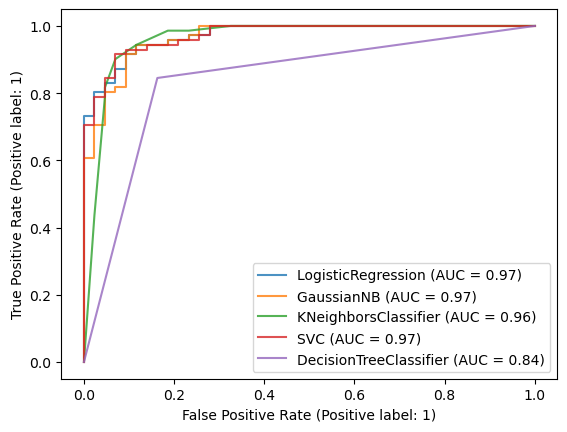

In [11]:
from sklearn.metrics import RocCurveDisplay

ROC_plot = plt.plot()

bestimators = [e[0] for e in best_results]

for estimator in bestimators:
    ax = plt.gca()
    _disp = RocCurveDisplay.from_estimator(estimator, X_test, y_test, ax=ax, alpha=0.8)
    # ROC_plot.plot(ax=ax, alpha=0.8)
